# **Generative Artificial Intelligence (AI) in Data Science with TensorFlow**

## **Written by:** [Aarish Asif Khan](https://github.com/aarish47)

## **Date:** 23rd March 2024

## **Credits to:** [Tensorflow](https://www.tensorflow.org/tutorials/images/classification)

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# Distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

- # **`Important Note`**


The entire notebook doesn't solely use TensorFlow. I made some substitutions and adjustments, but I've also contributed in other ways. This is crucial, so please read this part first.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import pathlib
from tensorflow.keras.models import Sequential

In [2]:
# Define the URL of the dataset
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# Download the dataset and extract it
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=url, extract=True)

# Convert the path to a pathlib.Path object and remove the file extension
data_dir = pathlib.Path(data_dir).with_suffix('')

# Print the path where the dataset is stored
print("Dataset downloaded and stored at:", data_dir)


Dataset downloaded and stored at: C:\Users\nawaz\.keras\datasets\flower_photos


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


- This means that we have 3670 total Images in the dataset!

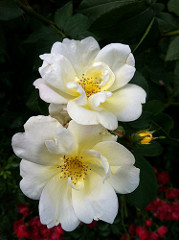

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

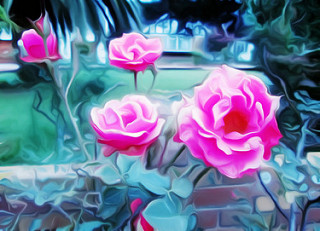

In [5]:
PIL.Image.open(str(roses[25])) # You can select any Image

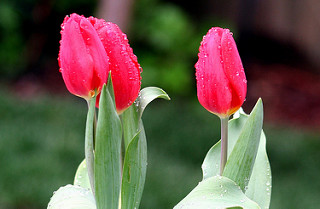

In [6]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

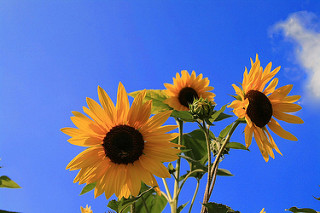

In [7]:
sunflowers = list(data_dir.glob('sunflowers/*'))
PIL.Image.open(str(sunflowers[10]))

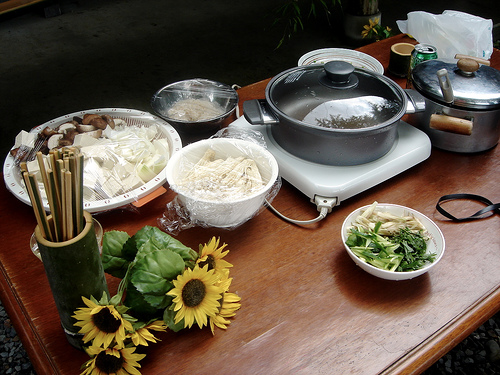

In [8]:
PIL.Image.open(str(sunflowers[25])) # You can select any Image

# **Load data using a Keras utility**

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # 80 percent of the data goes for Training and 20 percent goes for Validation
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # 80 percent of the data goes for Training and 20 percent goes for Validation
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [13]:
# Check shape of the data
for image_batch, labels_batch in train_ds.take(1):
  print(image_batch.shape)

(32, 180, 180, 3)


# **Visualize the data**

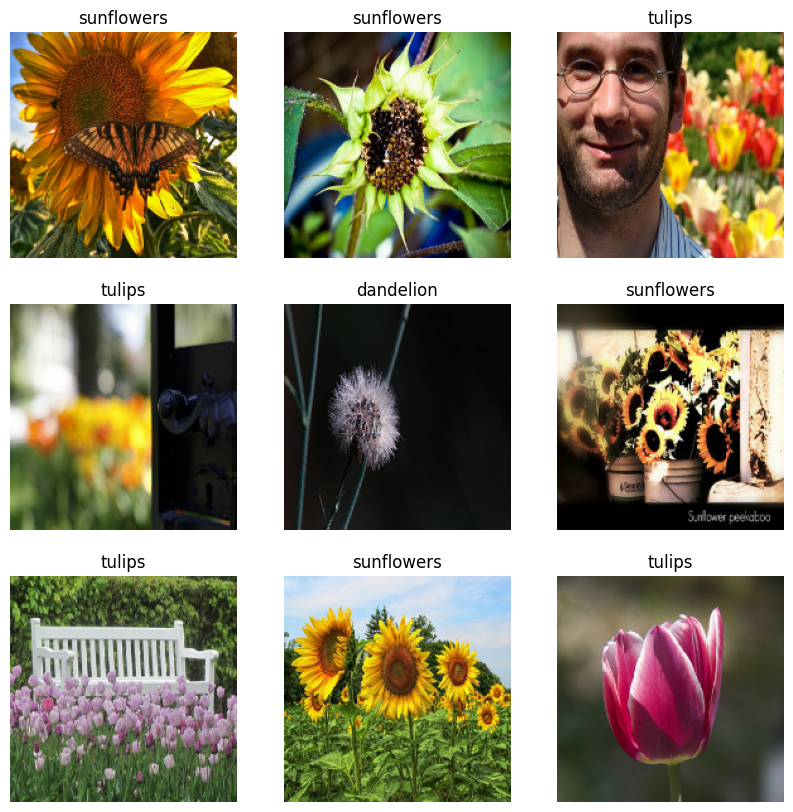

In [14]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# **Configure the dataset for performance**

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

# **Why we use Autotune?**


We "autotune" the data to make our process more efficient and effective. Autotuning basically means automatically adjusting certain parameters or settings based on the characteristics of the data or the system we're working with.

In the context of machine learning or data processing, autotuning helps us find the best configuration or setup without needing to manually try out different options. 

For example, when training a model, there might be parameters like learning rate or batch size that can greatly affect performance. Instead of guessing what values might work best, we can use autotuning techniques to automatically adjust these parameters based on how the training is progressing and the nature of the data.

Autotuning can save a lot of time and effort because it allows us to quickly find optimal settings without the need for extensive trial and error. It's like having a smart assistant that can analyze the situation and make adjustments on the fly to ensure we're getting the best results possible.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # cache() keeps images in memory after they're loaded off disk during the first epoch
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) # prefetch() overlaps data preprocessing and model execution while training

# **Standardize the data**

In [16]:
normalization_layer = layers.Rescaling(1./255) # rescale pixel values from [0, 255] to [0, 1]

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9994554


# **Creating a basic Keras model**

In [20]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [19]:
classes = len(class_names)
print(classes)

5


In [22]:
classes = len(class_names)
print(classes)

# Creating a model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(classes)
])

5


# **Compile the Model**

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)        1

# **Train the Model**

In [25]:
# Train the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10


92/92 [==============================] - 50s 519ms/step - loss: 1.4609 - accuracy: 0.3825 - val_loss: 1.1434 - val_accuracy: 0.5463
Epoch 2/10
92/92 [==============================] - 49s 532ms/step - loss: 1.0636 - accuracy: 0.5780 - val_loss: 0.9589 - val_accuracy: 0.6403
Epoch 3/10
92/92 [==============================] - 48s 520ms/step - loss: 0.8735 - accuracy: 0.6720 - val_loss: 0.8896 - val_accuracy: 0.6621
Epoch 4/10
92/92 [==============================] - 47s 506ms/step - loss: 0.7262 - accuracy: 0.7241 - val_loss: 0.8438 - val_accuracy: 0.6703
Epoch 5/10
92/92 [==============================] - 49s 537ms/step - loss: 0.4956 - accuracy: 0.8253 - val_loss: 0.8889 - val_accuracy: 0.6649
Epoch 6/10
92/92 [==============================] - 49s 530ms/step - loss: 0.3417 - accuracy: 0.8835 - val_loss: 1.0362 - val_accuracy: 0.6635
Epoch 7/10
92/92 [==============================] - 47s 508ms/step - loss: 0.2185 - accuracy: 0.9257 - val_loss: 1.2426 - val_accuracy: 0.65

# **Evaluation**

In [26]:
# print the final training and validation accuracy + loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# print the final training and validation accuracy + loss
print(f"----{'-'*10}----")
print("Training accuracy: {:.2f}".format(acc[-1]))
print("Validation accuracy: {:.2f}".format(val_acc[-1]))
print(f"----{'-'*10}----")
print("Training loss: {:.2f}".format(loss[-1]))
print("Validation loss: {:.2f}".format(val_loss[-1]))

------------------
Training accuracy: 0.98
Validation accuracy: 0.65
------------------
Training loss: 0.07
Validation loss: 1.51


# **Visualize the Results**

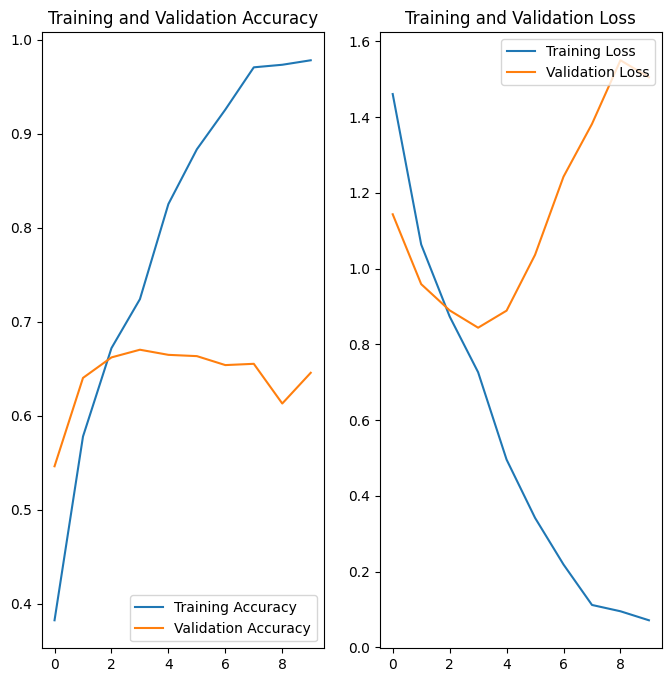

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Overfitting**

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. You'll use `data augmentation` and add `dropout` to your model.

# **Data augmentation**


Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom. These can be included inside your model like other layers, and run on the GPU.

In [29]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

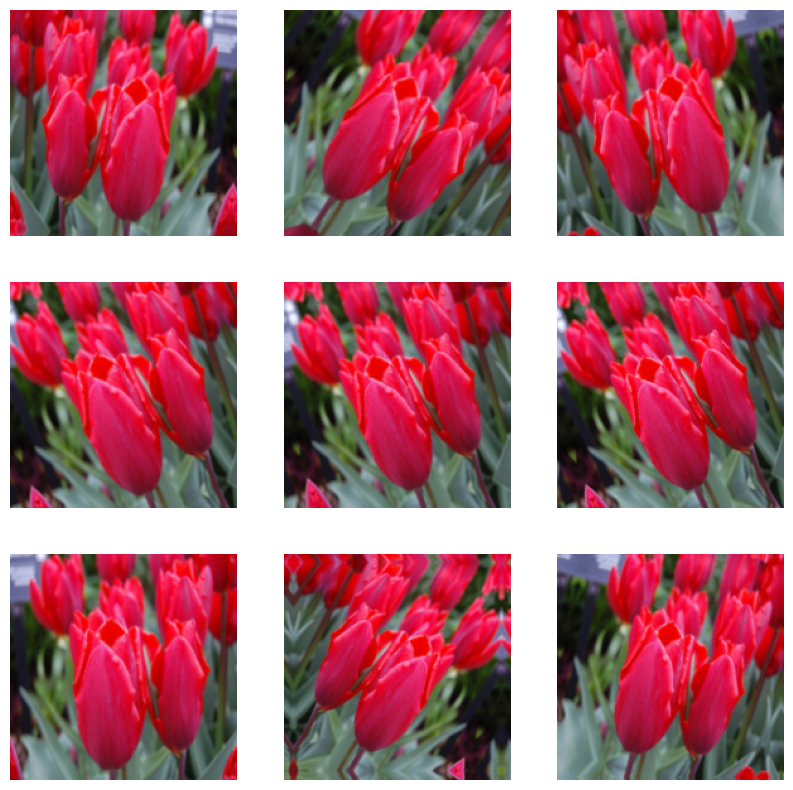

In [30]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

- The code above is an Example of Data augmentation!

# **Dropout**

Another technique to reduce overfitting is to introduce dropout{:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with tf.keras.layers.Dropout before training it using the augmented images:

In [32]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(classes, name="outputs")
])

# **Compile the Model**

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
# Check the Summary of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

# **Train the Model**

In [37]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15,
  verbose=0
)

# **Evaluation**

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Print the final training and validation accuracy + loss
print(f"----{'-'*10}----")
print("Training accuracy: {:.2f}".format(acc[-1]))
print("Validation accuracy: {:.2f}".format(val_acc[-1]))
print(f"----{'-'*10}----")
print("Training loss: {:.2f}".format(loss[-1]))
print("Validation loss: {:.2f}".format(val_loss[-1]))

------------------
Training accuracy: 0.79
Validation accuracy: 0.73
------------------
Training loss: 0.54
Validation loss: 0.73


# **Visualize the Results**

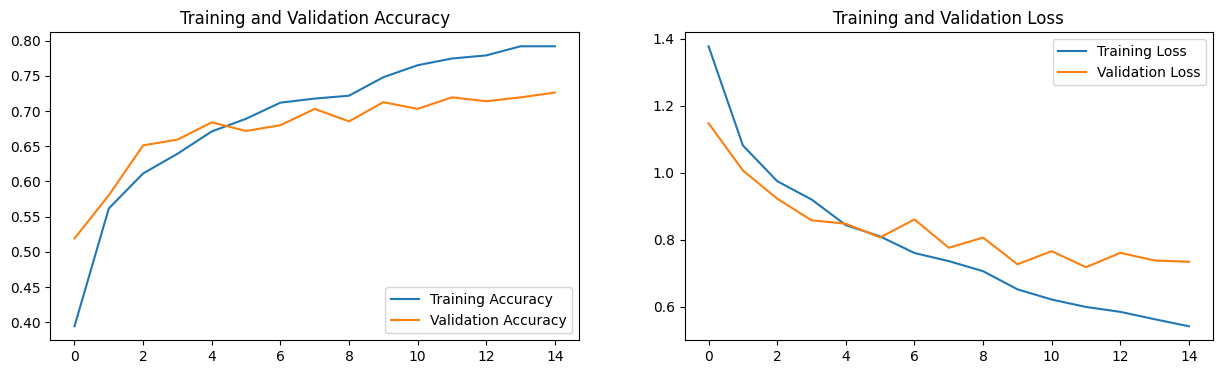

In [40]:
epochs_range = range(15)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Prediction on New data**

In [41]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 200ms/step
This image most likely belongs to sunflowers with a 99.26 percent confidence.


# **Use TensorFlow Lite**

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

# **Convert the Keras Sequential model to a TensorFlow Lite model**

To use the trained model with on-device applications, first convert it to a smaller and more efficient model format called a TensorFlow Lite model.

Take the trained Keras Sequential model and use tf.lite.TFLiteConverter.from_keras_model to generate a TensorFlow Lite model:

In [42]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\nawaz\AppData\Local\Temp\tmp6197jquk\assets


INFO:tensorflow:Assets written to: C:\Users\nawaz\AppData\Local\Temp\tmp6197jquk\assets


# **Run the TensorFlow Lite model**

In [43]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

- Print the signatures from the converted model to obtain the names of the inputs (and outputs):

In [44]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}